In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# ===================== 1. 2D小车运动学模型 =====================
class DiffDriveCar:
    def __init__(self, x=0.0, y=0.0, yaw=0.0, L=0.5):
        """
        差分驱动小车（简化阿克曼模型）
        :param x/y: 初始坐标
        :param yaw: 初始航向角（弧度）
        :param L: 车轮轴距
        """
        self.x = x
        self.y = y
        self.yaw = yaw
        self.L = L  # 轴距
        self.dt = 0.1  # 控制步长

    def update(self, v, steer):
        """
        小车状态更新（欧拉积分）
        :param v: 线速度 (m/s)
        :param steer: 转向角 (弧度)
        """
        # 阿克曼模型：角速度 = v * tan(steer) / L
        omega = v * np.tan(steer) / self.L
        
        # 状态更新
        self.x += v * np.cos(self.yaw) * self.dt
        self.y += v * np.sin(self.yaw) * self.dt
        self.yaw += omega * self.dt
        # 航向角归一化到[-π, π]
        self.yaw = np.arctan2(np.sin(self.yaw), np.cos(self.yaw))

    def get_state(self):
        return np.array([self.x, self.y, self.yaw])

# ===================== 2. MPPI核心实现 =====================
class MPPI:
    def __init__(self, car, target_pos, 
                 num_samples=500,  # 控制序列采样数
                 pred_horizon=15,  # 预测时域（步数）
                 lambda_=0.1,      # 温度系数（越小，权重越集中）
                 v_cov=0.1,        # 速度控制噪声方差
                 steer_cov=0.05):  # 转向角控制噪声方差
        self.car = car
        self.target = np.array(target_pos)
        self.N = num_samples    # 采样数
        self.T = pred_horizon  # 预测步长
        self.lambda_ = lambda_  # 温度系数
        self.dt = car.dt

        # 控制量范围（防止控制量过大）
        self.v_min, self.v_max = 0.0, 1.0    # 线速度范围
        self.steer_min, self.steer_max = -np.pi/4, np.pi/4  # 转向角范围

        # 控制噪声协方差（速度+转向角）
        self.cov = np.diag([v_cov, steer_cov])
        # 上一次的控制序列均值（初始为0）
        self.prev_u = np.zeros((self.T, 2))

    def _predict_trajectory(self, init_state, u_seq):
        """
        预测单个控制序列对应的轨迹
        :param init_state: 初始状态 [x,y,yaw]
        :param u_seq: 控制序列 (T, 2) → 每行是[v, steer]
        :return: 轨迹 (T+1, 3)
        """
        x, y, yaw = init_state
        traj = np.zeros((self.T+1, 3))
        traj[0] = [x, y, yaw]

        for t in range(self.T):
            v, steer = u_seq[t]
            # 运动学模型（和小车一致）
            omega = v * np.tan(steer) / self.car.L
            x += v * np.cos(yaw) * self.dt
            y += v * np.sin(yaw) * self.dt
            yaw += omega * self.dt
            yaw = np.arctan2(np.sin(yaw), np.cos(yaw))
            traj[t+1] = [x, y, yaw]
        return traj

    def _calc_cost(self, traj):
        """
        计算轨迹代价（目标跟踪+控制惩罚）
        :param traj: 轨迹 (T+1, 3)
        :return: 总代价
        """
        # 1. 目标跟踪代价：轨迹终点到目标的距离（加权90%）
        end_pos = traj[-1, :2]
        dist_cost = np.linalg.norm(end_pos - self.target) * 0.9
        
        # 2. 控制惩罚：控制量的L2范数（防止急刹/急转，加权10%）
        u_seq = self._get_u_from_traj(traj)  # 从轨迹反推控制量（简化版）
        control_cost = np.sum(np.square(u_seq)) * 0.1 * self.dt
        
        return dist_cost + control_cost

    def _get_u_from_traj(self, traj):
        """简化：从轨迹反推控制量（仅用于代价计算）"""
        u_seq = np.zeros((self.T, 2))
        for t in range(self.T):
            x1, y1, yaw1 = traj[t]
            x2, y2, yaw2 = traj[t+1]
            # 线速度 = 位移 / dt
            v = np.linalg.norm([x2-x1, y2-y1]) / self.dt
            # 转向角 = arctan( (yaw2-yaw1)*L / (v*dt) )
            omega = (yaw2 - yaw1) / self.dt
            steer = np.arctan(omega * self.car.L / (v + 1e-6))  # 防止除0
            u_seq[t] = [v, steer]
        return u_seq

    def solve(self):
        """
        MPPI核心求解：采样→预测→代价→加权
        :return: 最优控制的第一步 [v, steer]
        """
        init_state = self.car.get_state()
        
        # 1. 采样带噪声的控制序列：N个序列，每个序列T步，每步2维控制
        # 基础：上一次的控制序列均值 + 高斯噪声
        noise = np.random.multivariate_normal(
            mean=[0, 0], cov=self.cov, size=(self.N, self.T)
        )
        u_samples = self.prev_u + noise  # (N, T, 2)

        # 2. 控制量裁剪（防止超出范围）
        u_samples[:, :, 0] = np.clip(u_samples[:, :, 0], self.v_min, self.v_max)
        u_samples[:, :, 1] = np.clip(u_samples[:, :, 1], self.steer_min, self.steer_max)

        # 3. 预测所有采样序列的轨迹，并计算代价
        costs = np.zeros(self.N)
        trajs = []
        for i in range(self.N):
            traj = self._predict_trajectory(init_state, u_samples[i])
            trajs.append(traj)
            costs[i] = self._calc_cost(traj)

        # 4. 计算权重（softmax，代价越小权重越大）
        costs -= np.min(costs)  # 数值稳定
        weights = np.exp(-costs / self.lambda_)
        weights /= np.sum(weights)  # 归一化

        # 5. 加权更新控制序列均值
        self.prev_u = np.sum(weights[:, None, None] * u_samples, axis=0)

        # 6. 返回第一步控制量执行
        return self.prev_u[0]



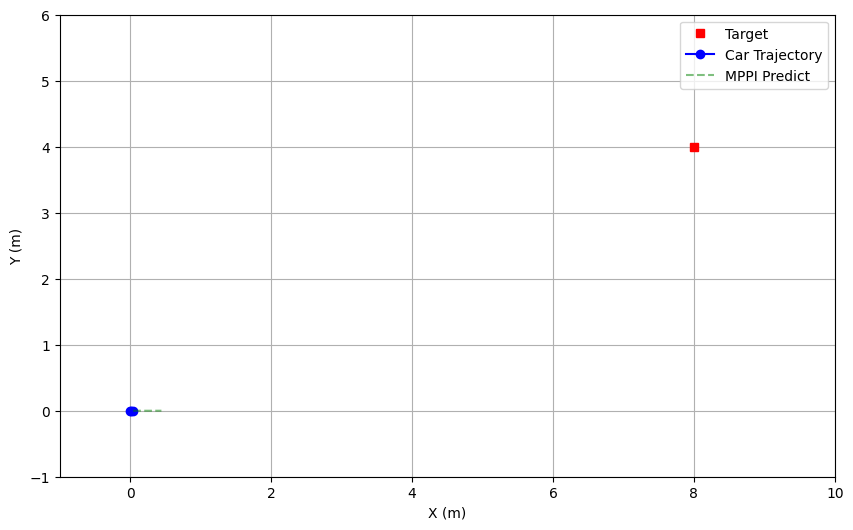

In [2]:
# ===================== 3. 测试+可视化 =====================
if __name__ == "__main__":
    # 1. 初始化小车和目标点
    car = DiffDriveCar(x=0.0, y=0.0, yaw=0.0)  # 小车初始位置(0,0)，航向0
    target = [8.0, 4.0]  # 目标点(8,4)
    
    # 2. 初始化MPPI
    mppi = MPPI(car, target, num_samples=500, pred_horizon=15)
    
    # 3. 可视化配置
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(-1, 10)
    ax.set_ylim(-1, 6)
    ax.grid(True)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.plot(target[0], target[1], 'rs', label="Target")  # 目标点
    car_line, = ax.plot([], [], 'bo-', label="Car Trajectory")  # 小车轨迹
    pred_line, = ax.plot([], [], 'g--', alpha=0.5, label="MPPI Predict")  # 预测轨迹
    ax.legend()

    # 存储小车历史轨迹
    history = [car.get_state()[:2]]

    def update_frame(frame):
        # 1. MPPI求解最优控制
        v, steer = mppi.solve()
        
        # 2. 小车执行控制
        car.update(v, steer)
        
        # 3. 记录历史轨迹
        history.append(car.get_state()[:2])
        history_np = np.array(history)
        car_line.set_data(history_np[:, 0], history_np[:, 1])
        
        # 4. 绘制MPPI预测的下一条轨迹（可视化用）
        init_state = car.get_state()
        pred_traj = mppi._predict_trajectory(init_state, mppi.prev_u)
        pred_line.set_data(pred_traj[:, 0], pred_traj[:, 1])
        
        # 5. 停止条件：到达目标附近（距离<0.2）
        if np.linalg.norm(car.get_state()[:2] - target) < 0.2:
            ani.event_source.stop()
            print("到达目标！")
        
        return car_line, pred_line

    # 动画运行（每秒10帧，对应小车dt=0.1）
    ani = FuncAnimation(fig, update_frame, frames=100, interval=100, blit=True)
    plt.show()